## 03. Building Templates of Spectroscopic Images in the Slitless Mode 

The end goal is to reconstruct the spectral information from each star given an image with many stars in the slitless mode. This notebook is solely dedicated towards building a template library, with all possible star combinations that for the time being follow these guidelines:

1. The stars are either hot or cold (blue or red)
2. The velociy information remains unresolved due to a very damping LSF
3. The stars contain the same log g

The notebook is divided into the following sections:

1. Defining the input parameters
2. Constructing all possible hot/cold combinations for #stars in FOV
3. Saving all these templates in template directory

Script written by: **Soumya Shreeram** <br/> 
Project supervised by: **Nadine Neumayer and Francisco Nogueras-Lara (MPIA)** <br/>
Date: **16th October 2020** <br/>

In [24]:
import astropy.units as u
import astropy.io.fits as fits

from scipy.sparse import csr_matrix
import scipy.stats as stats
import numpy as np
import os
import importlib

# generate random integer values
from random import seed
from random import randint

# plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

# to show progress during computations
from time import sleep
import sys

import matplotlib
import seaborn as sns

# for manupilating spectra
from specutils.manipulation import (box_smooth, gaussian_smooth, trapezoid_smooth)
from specutils import Spectrum1D

# for doing combinatorics with spectra
from itertools import permutations

In [2]:
%matplotlib inline
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

In [12]:
sys.path.append('imported_files/')
import Simulating_Spectra as ss
import plotting as pt
import Slitless_spec_forward_modelling as ssfm

#### 1. Defining the input parameters

In [54]:
# array containing the wavelength values for all the spectra
wave_filename = 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'

# setting up the working directory path
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Data")

num_stars = 10
l_pix, u_pix = 0, 2000
generate_new_pos = False
x_pos, y_pos = ss.starPositions(l_pix, u_pix, num_stars, generate_new_pos,\
                             'Data/pos_arr.npy')

# wavelength to pixel conversions
delta_lambda = 0.0005  # micro meter ==  1 pixel
k_band_lambda0 = 2.2
k_band_range = 0.3 # micro meter

# corresponsing resolution and dispersion size
r = k_band_lambda0/delta_lambda
disperse_range = k_band_range/delta_lambda 
print('The spectra is dispersed over %d pixels'%disperse_range)

dispersion_angle = 0 # degrees

# number of spectra
num_spectra = num_stars

# parameters considered :: [t_eff, log_g, Fe_H, alpha, spectral_types]
num_params = 5

# limits for for k-band range
k_upper, k_lower = 2.4e4, 2.1e4 # units are in angstrom

# define color palatte
pal = sns.hls_palette(num_spectra, h=.2).as_hex()

The spectra is dispersed over 600 pixels


#### 2. Loading the spectra (with LSF applied) 

In [7]:
# Load the 10 random spectra with added LSF, which can be associated with the stars in the FOV.
flux_LSF2D, params = np.load('Data/flux_K2D_LSF.npy'), np.load('Data/params.npy')
waves_k = np.load('Data/waves_k.npy')

# division of stars chosen in FOV, considering 10 temperatures with 10 log g's
stars_divide = [0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9]

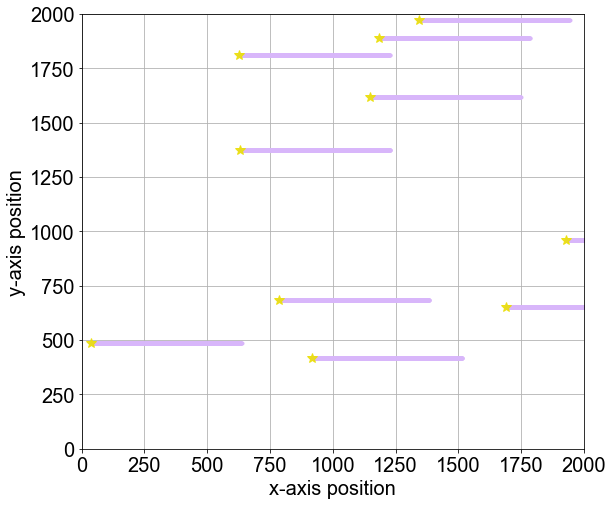

In [10]:
x_disperse, y_disperse = pt.plotDispersedStars(x_pos, y_pos, l_pix, u_pix, \
                                               disperse_range, waves_k, \
                                               dispersion_angle)

Nominclature of the template files generated:
fluxMatrix_s#1_p#2.npy where, #1 is the number of stars for which the template is generated and #2 is the permutation number label.

In [53]:
flux_k2D, type_id = ssfm.associateSpectraToStars(waves_k, stars_divide, num_stars, \
                                  flux_LSF2D, params)

# generate all possible permutations that exist for the given distribution of stars
perms_arr = ssfm.constructSpectralTemplates(u_pix, y_disperse, x_disperse, type_id, \
                                            flux_k2D)

1 stars at Teff = 12000 K, log g = 6.0
0 stars at Teff = 11800 K, log g = 2.5
0 stars at Teff = 10000 K, log g = 3.0
0 stars at Teff = 8400 K, log g = 6.0
0 stars at Teff = 7600 K, log g = 3.5
0 stars at Teff = 6900 K, log g = 3.0
0 stars at Teff = 5900 K, log g = 3.0
0 stars at Teff = 5100 K, log g = 2.0
0 stars at Teff = 4700 K, log g = 1.5
9 stars at Teff = 3900 K, log g = 6.0


In [79]:
importlib.reload(ssfm)

data_flux_matrix2D = np.load('Data/flux_LSF_2Dmatrix.npy')

diff_arr, min_idx, diff_mat3D = ssfm.calDiffDataTemplate(u_pix, num_stars, perms_arr, data_flux_matrix2D)

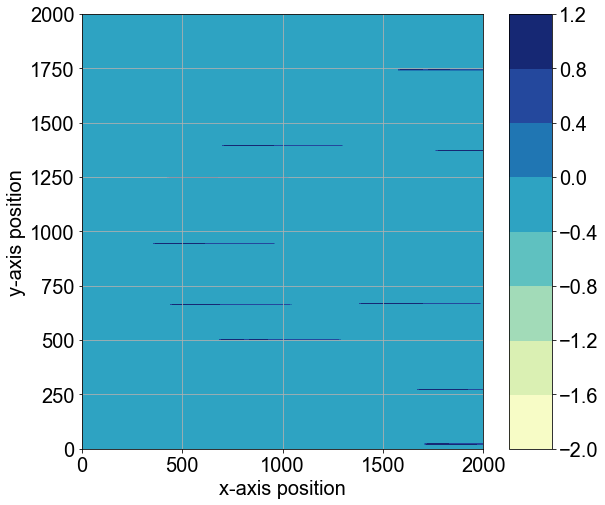

In [81]:
pt.plotContour(l_pix, u_pix, diff_mat3D[1])

In [78]:
print(diff_arr)
perms_arr[min_idx]

[-279.8510731360708, -4431.547722741149, -8583.244372346226, -12734.941021951305, -16886.637671556386, -21038.33432116146, -25190.030970766536, -29341.727620371617, -33493.4242699767, -37645.12091958178]


(9, 9, 9, 9, 9, 9, 9, 9, 9, 0)